In [196]:
import time
import copy
import sys
from collections import OrderedDict

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
import numpy as np

In [198]:
# Using CIFAR-10 again as in Assignment 1
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='/home/jovyan/harvard-heavy/xin/cifar10_data/', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='/home/jovyan/harvard-heavy/xin/cifar10_data/', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [199]:
# Using same ConvNet as in Assignment 1
'''
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)
'''

class ConvNet(nn.Module):
    '''
    From https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [200]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

In [201]:
## for test
test_corr = DatasetSplit(testset, [1,2,3])
len(test_corr)

3

In [202]:
def train(epoch, device):
    net.train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.cuda(), targets.cuda()
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = device['criterion'](outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
    sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
    sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device):
    net.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)
    return acc

In [203]:
def create_device(net, device_id, trainset, data_idxs, criterion, lr=0.01,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9,
                                weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=2)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'criterion': criterion,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }
    
def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentage of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''

    # total number of samples in the dataset
    total_samples = len(dataset)

    # Part 1.1: Implement!
    device_samples = round(data_pct * total_samples)
    return {i: torch.randperm(total_samples)[:device_samples].tolist() 
            for i in range(num_devices)}

def noniid_sampler(dataset, num_users, num_shards_per_user=2):
    """
    Sample non-I.I.D client data from dataset
    """
    total_num_imgs = len(dataset)
    num_shards = int(num_shards_per_user*num_users)
    num_imgs = int(total_num_imgs/num_shards)

    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = np.array(dataset.targets)

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    # idxs_labels[1, :].argsort(): sort idxs by classes
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()].astype(int)
    # idxs_labels:
    # array([[30207,  5662, 55366, ..., 23285, 15728, 11924],
    #        [    0,     0,     0, ...,     9,     9,     9]])
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, num_shards_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0).astype(int)
    return dict_users


In [204]:
def fisher_matrix_diag(device, batch_size=None):
    # Init
    model = device['net']
    batch_size = len(device['dataloader'].dataset) if batch_size is None else batch_size
    dataloader =  torch.utils.data.DataLoader(device['dataloader'].dataset,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     num_workers=0)
    fisher={}
    for n,p in model.named_parameters():
        fisher[n]=torch.zeros_like(p.data)
    # Compute
    model.train()
    for image, target in dataloader:
        image, target = image.cuda(), target.cuda()
        # Forward and backward
        model.zero_grad()
        output=model.forward(image)
        loss=criterion(output, target)
        loss.backward()
        # Get gradients
        for n,p in model.named_parameters():
            if p.grad is not None:
                fisher[n]+=image.size(0)*p.grad.data.pow(2)
                
    for n,_ in model.named_parameters():
        fisher[n]=fisher[n]/len(dataloader)
        fisher[n].requires_grad=False
    return fisher

'''
def update_fisher_params(self, current_ds, batch_size, num_batch=None):
    dl = DataLoader(current_ds, batch_size, shuffle=True)
    log_liklihoods = []
    for i, (input, target) in enumerate(dl):
        if num_batch is not None:
            if i > num_batch:
                break
        output = F.log_softmax(self.model(input), dim=1)
        log_liklihoods.append(output[:, target])
    log_likelihood = torch.cat(log_liklihoods).mean()
    grad_log_liklihood = autograd.grad(log_likelihood, self.model.parameters())
    _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
    for _buff_param_name, param in zip(_buff_param_names, grad_log_liklihood):
        self.model.register_buffer(_buff_param_name+'_estimated_fisher', param.data.clone() ** 2)
'''       

def get_fisher_criterion(criterion, fisher, model, model_old, lamb):
    # Regularization for all previous tasks
    def fisher_criterion(output, target):
        loss_reg=0
        for (name,param),(_,param_old) in zip(model.named_parameters(), model_old.named_parameters()):
            loss_reg+=torch.sum(fisher[name].detach()*(param_old.detach()-param)**2)/2.0
            
        print(' N: %f, R: %f' % (criterion(output,target).item(), lamb*loss_reg.item()))

        return criterion(output, target) + lamb*loss_reg

    return fisher_criterion

In [205]:
def average_weights(devices):
    '''
    Returns the average of the weights.
    '''
    # Part 1.2: Implement!
    w = [device['net'].state_dict() for device in devices]
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
        
    return w_avg


def zeros_like_copy(in_state_dict):
    out_state_dict = {}
    for key in in_state_dict.keys():
        out_state_dict[key] = torch.zeros_like(in_state_dict[key])
    return out_state_dict
    

def fisher_average_weights(devices):
    w = [device['net'].state_dict() for device in devices]
    fisher = [device['fisher'] for device in devices]
    
    w_avg = zeros_like_copy(w[0])
    w_sum_fisher = zeros_like_copy(w[0])
    
    for key in w_avg.keys():
        for i in range(len(w)):
            try:
                fisher_matrix = fisher[i][key] + 1e-12
                # fisher_matrix = torch.ones_like(w[i][key])
            except:
                fisher_matrix = torch.ones_like(w[i][key])
                
            w_avg[key] += w[i][key]*fisher_matrix
            w_sum_fisher[key] += fisher_matrix
            
        w_avg[key] /= w_sum_fisher[key]
        
    return w_avg
    

def get_devices_for_round(devices, device_pct):
    '''
    '''
    # Part 1.2: Implement!
    num_devices_in_round = round(device_pct*len(devices))
    device_idxs = np.random.permutation(len(devices))[:num_devices_in_round]
    return [devices[i] for i in device_idxs]

In [206]:

net = ConvNet().cuda()
criterion = nn.CrossEntropyLoss()



# Part 1.3: Implement device creation here
# devices = [create_device(net, i, trainset, data_idxs[i])
#            for i in range(num_devices)]

center_device = create_device(net, 50000, trainset, list(range(50000)), criterion)

# train devices[0]
for i in range(3):
    train(i, center_device)
    test(i, center_device)
    center_device['scheduler'].step()

(Device 50000/Epoch 0) Train Loss: 1.954 | Train Acc: 26.770 | Test Loss: 1.674 | Test Acc: 39.040
(Device 50000/Epoch 1) Train Loss: 1.600 | Train Acc: 41.538 | Test Loss: 1.424 | Test Acc: 47.730
(Device 50000/Epoch 2) Train Loss: 1.460 | Train Acc: 46.842 | Test Loss: 1.351 | Test Acc: 51.480


In [207]:
center_device['fisher'] = fisher_matrix_diag(center_device, batch_size=1000)

In [208]:
center_device['fisher'].keys()

dict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [209]:
center_device['fisher']['fc1.weight']

tensor([[3.6198e-02, 4.5450e-02, 4.1812e-02,  ..., 3.4991e-03, 5.4573e-03,
         1.3211e-02],
        [4.1102e-03, 3.0456e-03, 4.6297e-03,  ..., 3.9451e-03, 3.9360e-03,
         4.1156e-03],
        [7.6085e-02, 8.2700e-02, 6.9721e-02,  ..., 4.6604e-02, 6.1892e-02,
         9.7317e-02],
        ...,
        [8.8975e-02, 9.2627e-02, 8.8999e-02,  ..., 2.0343e-02, 3.0740e-02,
         4.7966e-02],
        [3.9268e-04, 4.9155e-04, 5.7600e-04,  ..., 3.1808e-04, 2.9316e-04,
         6.5829e-04],
        [3.5846e-07, 5.2759e-07, 3.0858e-07,  ..., 1.6924e-07, 3.1421e-07,
         5.7537e-07]], device='cuda:0')

In [210]:
# plot_all_hist(center_device['fisher'])

In [211]:
rounds = 1
local_epochs = 20
num_devices = 50
device_pct = 0.08
data_pct = 0.02

# data_idxs = iid_sampler(trainset, num_devices, data_pct)
data_idxs = noniid_sampler(trainset, num_devices)


num_device = 15
devices=[create_device(net, i, trainset, data_idxs[i], criterion, lr=0.01)
                       for i in range(num_device)]

# center_device: real global, train on global dataset
# --- average_devices ---
# devices[0]: normal local training, normal average
# devices[1]: normal local training, fisher average
# devices[2]: fisher local training, normal average
# devices[3]: fisher local training, fisher average
# devices[4]: different scratch training, normal average
# devices[5]: different scratch training, fisher average
# --- round_devices ---
# devices[6-8]: w/ fisher reg
# devices[9-11]: w/o fisher reg
# devices[12-15]: from different scratch

## IID Federated Learning
start_time = time.time()
for round_num in range(rounds):
    # Part 1.3: Implement getting devices for each round here
    # round_devices = get_devices_for_round(devices, device_pct)
    round_devices = devices[6:]  # we have num_device - 6
    
    for round_device_idx, device in enumerate(round_devices):
        if round_device_idx<=5:
            # load global model 
            device['net'].load_state_dict(center_device['net'].state_dict())
        if round_device_idx<=2:
            device['criterion'] = get_fisher_criterion(criterion=criterion, fisher=center_device['fisher'], model=device['net'], model_old=center_device['net'], lamb=5)
        

    print('Round: ', round_num)
    for device_idx, device in enumerate(round_devices):
        # if device_idx<=4:
        #     continue
        # test(-1, device)
        for local_epoch in range(local_epochs):
            train(local_epoch, device)


Round:  0
 N: 1.492965, R: 0.000000
 N: 1.032379, R: 0.026290
 N: 0.804015, R: 0.109979
 N: 0.455020, R: 0.158421
 N: 0.922972, R: 0.194773
 N: 0.522135, R: 0.204204
 N: 0.650181, R: 0.220291
 N: 0.576579, R: 0.207091
(Device 6/Epoch 0) Train Loss: 0.947 | Train Acc: 66.000 N: 0.908305, R: 0.219183
 N: 0.641207, R: 0.207633
 N: 0.860012, R: 0.224769
 N: 0.855935, R: 0.215774
 N: 0.633683, R: 0.218315
 N: 0.853741, R: 0.238886
 N: 0.578473, R: 0.210186
 N: 0.522283, R: 0.222147
(Device 6/Epoch 1) Train Loss: 0.951 | Train Acc: 64.300 N: 0.684043, R: 0.244741
 N: 0.657532, R: 0.204565
 N: 0.538844, R: 0.188333
 N: 0.529476, R: 0.205138
 N: 0.626276, R: 0.180128
 N: 0.453936, R: 0.153841
 N: 0.472760, R: 0.160353
 N: 0.518772, R: 0.161181
(Device 6/Epoch 2) Train Loss: 0.747 | Train Acc: 72.700 N: 0.610179, R: 0.139672
 N: 0.471629, R: 0.136756
 N: 0.578114, R: 0.138138
 N: 0.450945, R: 0.124963
 N: 0.428355, R: 0.121728
 N: 0.494362, R: 0.114232
 N: 0.444406, R: 0.107008
 N: 0.406495, R:

In [212]:
center_device['test_acc_tracker'][-1]

51.48

In [213]:
round_devices[3].keys()

dict_keys(['net', 'id', 'dataloader', 'optimizer', 'scheduler', 'criterion', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker'])

In [214]:
round_devices[3]['test_acc_tracker']

[]

In [215]:
# Part 1.3: Implement weight averaging here
w_navg_freg = average_weights(round_devices[:3])
w_navg_nreg = average_weights(round_devices[3:6])
w_navg_fscra = average_weights(round_devices[6:])

   
devices[0]['net'].load_state_dict(w_navg_nreg)
devices[2]['net'].load_state_dict(w_navg_freg)
devices[4]['net'].load_state_dict(w_navg_fscra)

<All keys matched successfully>

In [216]:
for d in round_devices:
    d['criterion'] = criterion
    d['fisher'] = fisher_matrix_diag(d)

w_favg_freg = fisher_average_weights(round_devices[:3])
w_favg_nreg = fisher_average_weights(round_devices[3:6])
w_favg_fscra = fisher_average_weights(round_devices[6:])

devices[1]['net'].load_state_dict(w_favg_nreg)
devices[3]['net'].load_state_dict(w_favg_freg)
devices[5]['net'].load_state_dict(w_favg_fscra)

<All keys matched successfully>

In [217]:
def plot_all_hist(state_dict):
    big_tensor = []
    for key in state_dict.keys():
        big_tensor.append(state_dict[key].flatten())
    big_tensor = torch.cat(big_tensor)

    sns.distplot(np.log(abs(big_tensor.cpu().numpy())+1e-12))
    plt.xlabel('log(F_i)')

In [218]:
# test accuracy after aggregation
for i in range(6):
    acc = test(round_num, devices[i])
    print('%d device : %s' % (i, '-^'))
    print('-'*30 + '\n')

 | Test Loss: 3.671 | Test Acc: 12.520
0 device : -^
------------------------------

 | Test Loss: 5.421 | Test Acc: 18.920
1 device : -^
------------------------------

 | Test Loss: 2.570 | Test Acc: 28.460
2 device : -^
------------------------------

 | Test Loss: 2.970 | Test Acc: 29.080
3 device : -^
------------------------------

 | Test Loss: 4.169 | Test Acc: 10.000
4 device : -^
------------------------------

 | Test Loss: 8.699 | Test Acc: 18.460
5 device : -^
------------------------------



In [219]:
# test accuracy after aggregation
for i in [6, 7, 8, 9, 10, 11, 12, 13, 14]:
    acc = test(round_num, devices[i])
    print('%d device | train Acc: %f | test Acc: %f' % (i, devices[i]['train_acc_tracker'][-1], devices[i]['test_acc_tracker'][-1]))
    print('-'*30 + '\n')

 | Test Loss: 4.720 | Test Acc: 17.410
6 device | train Acc: 77.700000 | test Acc: 17.410000
------------------------------

 | Test Loss: 5.636 | Test Acc: 18.690
7 device | train Acc: 92.700000 | test Acc: 18.690000
------------------------------

 | Test Loss: 5.194 | Test Acc: 18.890
8 device | train Acc: 93.300000 | test Acc: 18.890000
------------------------------

 | Test Loss: 10.323 | Test Acc: 16.920
9 device | train Acc: 85.200000 | test Acc: 16.920000
------------------------------

 | Test Loss: 7.562 | Test Acc: 19.180
10 device | train Acc: 96.100000 | test Acc: 19.180000
------------------------------

 | Test Loss: 7.733 | Test Acc: 15.110
11 device | train Acc: 75.500000 | test Acc: 15.110000
------------------------------

 | Test Loss: 205.658 | Test Acc: 10.000
12 device | train Acc: 100.000000 | test Acc: 10.000000
------------------------------

 | Test Loss: 7.687 | Test Acc: 15.920
13 device | train Acc: 75.600000 | test Acc: 15.920000
------------------------

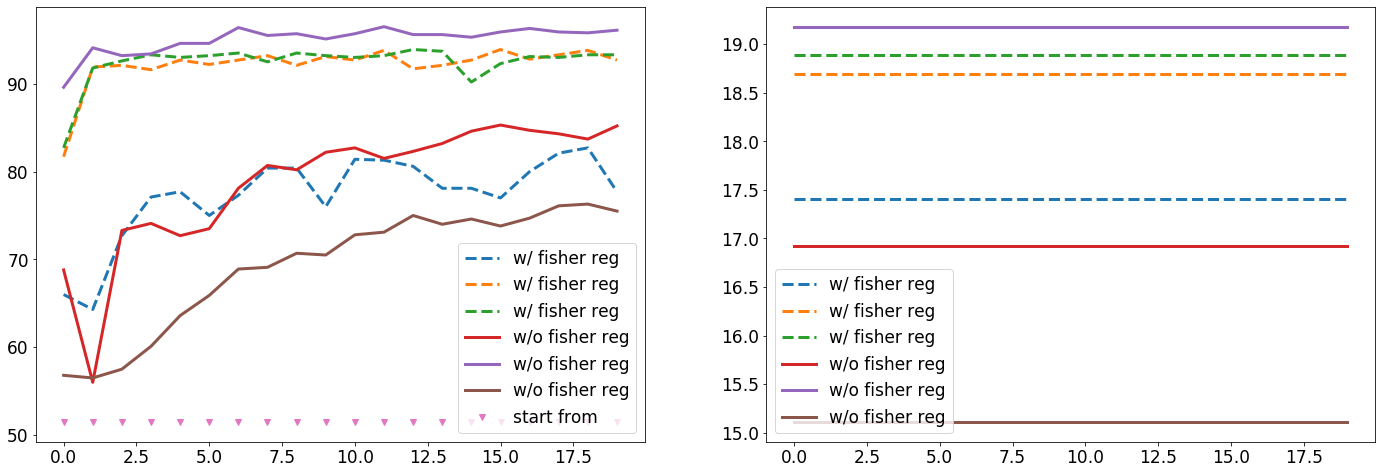

In [222]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[24,8])
for i in [6,7,8,9,10,11]:
    p = ax1.plot(devices[i]['train_acc_tracker'], label='w/ fisher reg' if i <=8 else 'w/o fisher reg', linewidth=3, linestyle='dashed' if i<=8 else 'solid')
    ax2.plot([devices[i]['test_acc_tracker'][-1]]*len(devices[i]['train_acc_tracker']), label='w/ fisher reg' if i <=8 else 'w/o fisher reg', color=p[0].get_color(), linewidth=3, linestyle='dashed' if i<=8 else 'solid')
    
ax1.plot([center_device['test_acc_tracker'][-1]]*len(devices[i]['train_acc_tracker']),'v', label='start from')
ax1.legend()
ax2.legend()

In [223]:
import jovian
jovian.commit(filename='lab.ipynb', message='ID:2 version 2')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "xindongol/lab" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/xindongol/lab
